In [1]:
import os, sys

# 1) Put the env’s DLL folders first on PATH
prefix = sys.prefix
priority = [rf"{prefix}\Library\bin", rf"{prefix}\bin", rf"{prefix}\DLLs"]
rest = [p for p in os.environ["PATH"].split(os.pathsep)
        if not any(p.lower().startswith(x.lower()) for x in priority)]
# Optionally drop CUDA/Intel/VS paths that drag in other OpenMP runtimes:
drop_substrings = ("oneapi", "intel", "cuda", "nvidia", "microsoft visual studio")
rest = [p for p in rest if not any(s in p.lower() for s in drop_substrings)]
os.environ["PATH"] = os.pathsep.join(priority + rest)

# 2) Force single-threaded math (stability)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"   # harmless if you’re on OpenBLAS

In [2]:
import ctypes
for dll in ("libgomp-1.dll", "vcomp140.dll", "libiomp5md.dll"):
    try:
        ctypes.CDLL(dll); print("Loaded:", dll)
    except OSError as e:
        print("Missing:", dll)

Loaded: libgomp-1.dll
Loaded: vcomp140.dll
Loaded: libiomp5md.dll


In [41]:
import numpy as np, pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [4]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"   # set before importing numpy/xgboost
os.environ["MKL_NUM_THREADS"] = "1"

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import hht_fe
import helpers

['d:\\Anaconda\\envs\\ml-cpu\\python311.zip', 'd:\\Anaconda\\envs\\ml-cpu\\DLLs', 'd:\\Anaconda\\envs\\ml-cpu\\Lib', 'd:\\Anaconda\\envs\\ml-cpu', '', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [5]:
import pandas as pd
import numpy as np

In [6]:
%xmode verbose
import faulthandler, sys
faulthandler.enable()
print(sys.getrecursionlimit())  # usually 1000

Exception reporting mode: Verbose
3000


In [37]:
def train_test_validate_model(X, y, feat_names = None):

    X_train, X_test, y_train, y_test = helpers.split_data(X, y, test_size = 0.25, random_state = 42, shuffle = True)
    y_train_pred, y_test_pred, model = helpers.train_and_predict_xgbc(X_train, y_train, X_test)
    roc_train, roc_test, test_thrs = helpers.calculate_roc((y_train, y_test), (y_train_pred, y_test_pred))
    best_thr = helpers.get_best_thr(roc_test[1], roc_test[0], test_thrs)
    y_test_pred_bin = np.where(y_test_pred >= best_thr, 1, 0)
    helpers.plot_roc(roc_train, roc_test, roc_bm = None)
    helpers.print_scores(y_test, y_test_pred_bin)

    if feat_names is not None:
        a = pd.Series(model.feature_importances_)
        b = pd.Series(feat_names)
        feat_importances = pd.concat((a, b), axis = 1)
    
    return model, feat_importances

In [ ]:
def extract_features(X_healthy, X_faulty, fs):
    
    hht_fe_class = hht_fe.HHT_FeatureExtraction()

    X_healthy, names_healthy = hht_fe_class.windowed_hht_table(X_healthy.values, fs)
    df_healthy = pd.DataFrame(data=X_healthy, columns=names_healthy)
    X_faulty, names_faulty = hht_fe_class.windowed_hht_table(X_faulty.values, fs)
    df_faulty = pd.DataFrame(data=X_faulty, columns=names_faulty)

    df_healthy['fault'] = 0
    df_faulty['fault'] = 1

    df_overall = pd.concat((df_healthy,df_faulty))
    df_overall = df_overall.sample(frac = 1) # shuffle df

    return df_overall

In [47]:
def train_and_display_dtc(X, y):

    dtc = DecisionTreeClassifier(random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    dtc.fit(X_train, y_train)

    y_test_pred = dtc.predict(X_test)
    helpers.print_scores(y_test, y_test_pred)

    plt.figure(figsize=(12, 8))
    plot_tree(dtc, feature_names=X.columns, class_names=True, filled=True, max_depth=3)
    plt.tight_layout()
    plt.show()

# Electrical Motor

In [9]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [10]:
df.columns.tolist()

['DE',
 'FE',
 'fault_diameter',
 'horse_power',
 'rounds_per_minute',
 'fault_end',
 'samples_per_second',
 'fault_element',
 'fault']

## 1730 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 7

In [11]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

(485643,)
(366988,)


In [12]:
df_features = extract_features(de_healthy, de_faulty, fs = 12000)
df_features

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,fault
412,0.032522,2.493430,1.829198,0.003717,0.350980,0.044778,0.010599,0.063575,2078.681815,207.682957,...,146.108482,1035.0,18.926707,1065.0,14.368286,1010.0,10.374209,30.0,9.873939,0
381,0.259928,5.154696,8.279410,-0.033725,0.560233,0.256521,0.242031,0.786706,3321.959665,342.299862,...,648.153735,105.0,153.548647,45.0,130.847533,205.0,97.428450,40.0,93.285288,1
715,0.034781,4.414353,3.122088,0.263703,0.344310,0.045767,0.017311,0.067105,1988.147212,385.627729,...,148.272368,30.0,14.023113,1035.0,13.846878,1065.0,11.254713,55.0,10.735165,0
558,0.033403,3.567575,2.267287,0.035587,0.346811,0.045396,0.013373,0.064319,2033.748011,305.819357,...,147.726334,1035.0,17.186193,1065.0,16.964310,30.0,14.849203,1010.0,8.836427,0
422,0.786154,3.958469,4.029917,0.007952,0.453105,0.939930,0.600083,2.229469,2698.481508,196.859880,...,2264.775369,105.0,460.827556,115.0,308.296144,150.0,290.898552,205.0,266.980354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.032303,3.307067,1.879388,-0.003159,0.349312,0.044438,0.010855,0.061194,2071.559537,226.681505,...,148.490834,1035.0,18.951080,1065.0,16.165150,30.0,11.587057,1010.0,9.943341,0
621,0.033245,4.419191,2.444461,0.046178,0.348062,0.044414,0.012405,0.063343,2058.713176,263.106943,...,148.673078,1035.0,18.372677,30.0,15.518407,1065.0,13.373271,1095.0,9.153867,0
545,0.034253,5.964623,3.783969,0.063901,0.348479,0.045349,0.016802,0.064219,2024.316026,318.346121,...,160.159701,1065.0,19.753742,30.0,16.429367,1035.0,15.826626,55.0,11.413899,0
758,0.033537,4.914957,3.061810,0.194113,0.347645,0.044872,0.015340,0.063448,2033.170017,319.893002,...,148.354396,1035.0,16.845178,1065.0,13.713274,30.0,11.673863,1040.0,8.357043,0


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


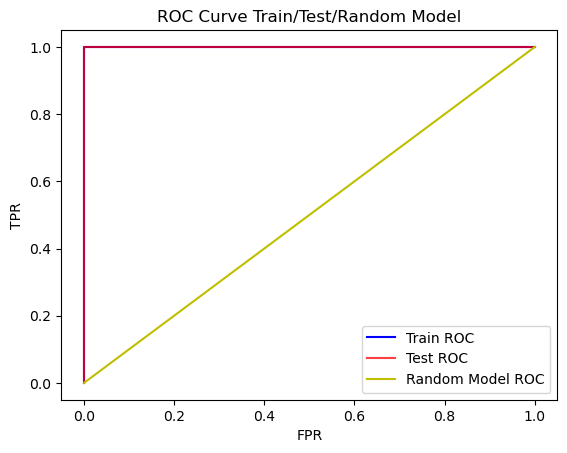

In [44]:
xgbc_1730_7, feat_importances = train_test_validate_model(X = df_features.iloc[:, :-1].values, y = df_features.iloc[:, -1].values, feat_names=df_features.columns.tolist())

In [45]:
feat_importances

,0,1
0,0.0,imf1_rms
1,0.0,imf1_crest
2,0.0,imf1_kurt
3,0.0,imf1_skew
4,1.0,imf1_zcr
...,...,...
81,0.0,env_peak4_freq
82,0.0,env_peak4_amp
83,0.0,env_peak5_freq
84,0.0,env_peak5_amp


This shows that a single feature is dominating

F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


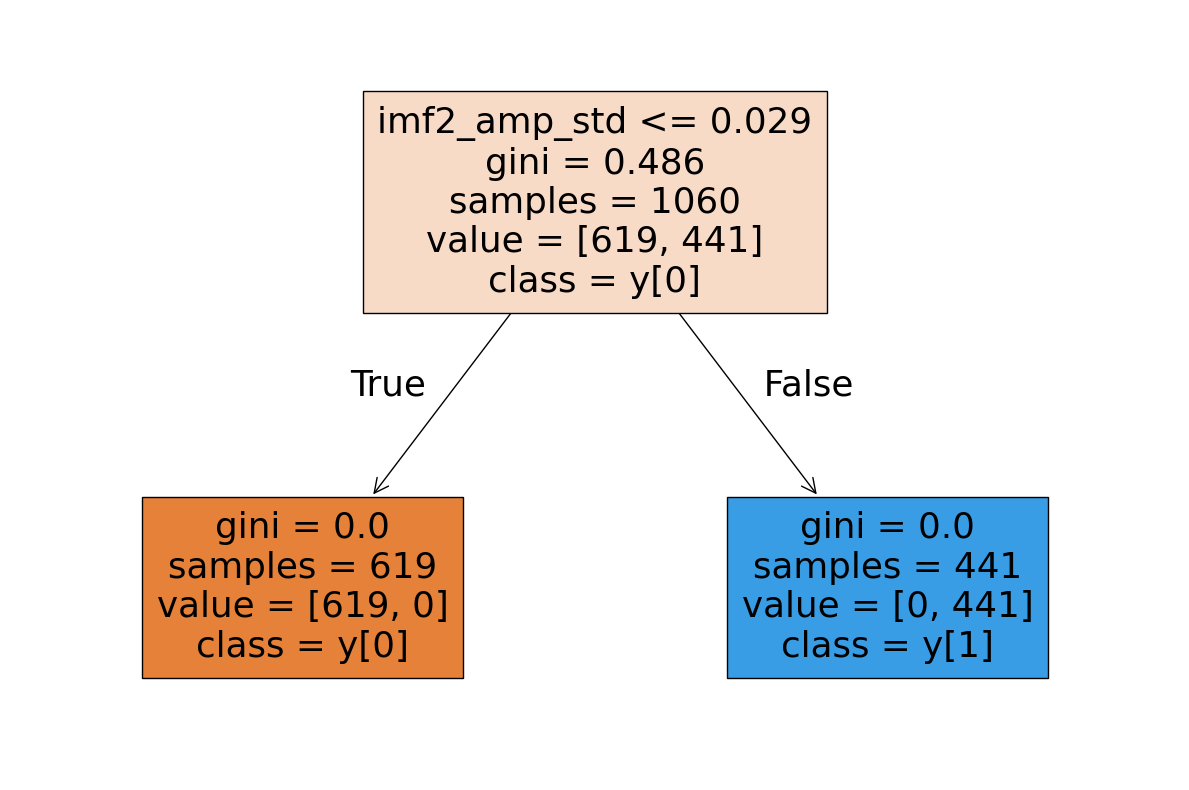

In [50]:
train_and_display_dtc(df_features.iloc[:, :-1], df_features.iloc[:, -1])

## 1730 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 21

## 1797 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 7

## 1797 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 21

# ICE

## RPM = 1000; Humidity = 50%, Temperature = 30

## RPM = 1500; Humidity = 50%, Temperature = 30

## RPM = 2000; Humidity = 50%, Temperature = 30